Сначала был сделан *Conditional GAN*, который долго обучался, поэтому в коде встречаются закомментированные куски кода на случай если я решу-таки сделать что-нибудь поинтереснее в дальнейшем

Импортируем модули и загрузим датасет

In [ ]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.compat.v1.keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from tensorflow.compat.v1.keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D,concatenate,LeakyReLU
#from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.compat.v1.keras.models import Model, load_model
from tensorflow.compat.v1.keras import backend as K


from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

Проверим температуру и загруженность *GPU*

In [2]:
!nvidia-smi

Sun May 10 16:38:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    21W / 250W |    211MiB / 11018MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   33C    P8    21W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

Разобьём датасет на трейн и тест

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

Зарегистрируем *tensorflow* сессию в *keras*, чтобы работать с переменными в рамках данной сессии

In [4]:
sess = tf.Session()
K.set_session(sess)

Артефакт: на случай, если я захочу запустить это всё на *tensorflow 1* я просто раскомменчу некоторые строки

In [5]:
#from keras import backend as K
#import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

#sess = tf.Session()
#K.set_session(sess)
#sess = tf.compat.v1.Session()
#tf.compat.v1.keras.backend.set_session(sess)

Определим основные гиперпараметры

In [5]:
batch_size = 256
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 4
num_classes = 10
dropout_rate = 0.3

Обучение модели из *tensorflow* $\Rightarrow$ батчи за нас никто не сделает. Ну что ж, напишем.

In [6]:
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]


train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)

Создаём *placeholders* для входных данных, чтобы подать их на вход в *keras*

In [7]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),   name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim),  name='z')

Напишем скоупы для кераса: первым имплементируем модель генератора

In [8]:
with tf.variable_scope('generator'):
#    x = concatenate([z, lbl])
    img = Input(tensor=x_)
    lbl = Input(tensor=y_)
    z   = Input(tensor=z_)
    x = Dense(7*7*64, activation='relu')(z)
    x = Dropout(dropout_rate)(x)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = UpSampling2D(size=(2, 2))(x)

    generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
#generator = Model([z, lbl], generated, name='generator')
generator = Model(z, generated, name='generator')
# Конечно же, саммари
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              15680     
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        102464    
__________________________________________

Очередь дискриминатора.

In [9]:
with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
#    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    
    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
#discrim = Model([img, lbl], d, name='Discriminator')
discrim = Model(img, d, name='Discriminator')
# Конечно же, саммари
discrim.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       6400      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)       

Соеденим модель. Тут видно, что можно применять модели сразу к *placeholder*, как обычную *tf*-операцию

In [10]:
#generated_z = generator([z, lbl])
generated_z = generator(z)

#discr_img   = discrim([img, lbl])
#discr_gen_z = discrim([generated_z, lbl])
discr_img   = discrim(img)
discr_gen_z = discrim(generated_z)


#gan_model = Model([z, lbl], discr_gen_z, name='GAN')
#gan   = gan_model([z, lbl])
gan_model = Model(z, discr_gen_z, name='GAN')
gan   = gan_model(z)

# Конечно же, саммари
gan_model.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         137409    
_________________________________________________________________
Discriminator (Model)        (None, 1)                 160257    
Total params: 297,666
Trainable params: 297,666
Non-trainable params: 0
_________________________________________________________________


Имплементация лоссов ошибки избражений - для реального и сгенерированного, плюс лоссы генератора и дискриминатора для них.

In [12]:
log_dis_img   = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5*(log_dis_gen_z + log_dis_img)

Мы не хотим, чтобы оптимизатор смотрел на ошибку дискриминатора, для построения своего лосса вытащим переменные, по которым минимизирует оптимизатор: *tf.get_collection*

In [13]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

# Переменные генератора и дискриминаторы (отдельно) для оптимизаторов
generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
discrim_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Запуск сессии инициализации переменных

In [14]:
sess.run(tf.global_variables_initializer())

Шаги генератора и дискриминатора

In [15]:
# Шаг генератора
#def step(image, label, zp):
def step(image, zp, i):
    l_dis, _ = sess.run([L_dis, step_gen], feed_dict={z:zp, img:image, K.learning_phase():1})
    #l_dis, _ = [L_dis, step_gen], feed_dict={z:zp, img:image, K.learning_phase():1}
    return l_dis

# Шаг дискриминатора
#def step_d(image, label, zp):
def step_d(image, zp):
    l_dis, _ = sess.run([L_dis, step_dis], feed_dict={z:zp, img:image, K.learning_phase():1})
    #l_dis, _ = [L_dis, step_dis], feed_dict={z:zp, img:image, K.learning_phase():1}
    return l_dis

Вспомогательный код для визуализации и сохранения картинок. Пригодится для гифки.

In [16]:
# Массивы в которые будем сохранять результаты, для последующей визуализации
figs = [] 
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((28 * n, 28 * n))
#    input_lbl = np.zeros((1, 10))
#    input_lbl[0, label] = 1.
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_generated = sess.run(generated_z, feed_dict={z:z_sample, K.learning_phase():0})
#            x_generated = generated_z, feed_dict={z:z_sample, K.learning_phase():0}
            digit = x_generated[0].squeeze()
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit
    if show:
        # Визуализация
        clear_output() # Не захламляем output
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


n_compare = 10
def on_n_period(period):

    figs.append(draw_manifold(show = True))
    periods.append(period)
    # Рисование многообразия для рандомного y
    #draw_lbl = np.random.randint(0, num_classes)    
    #print(draw_lbl)
    #for label in range(num_classes):
    #    figs[label].append(draw_manifold(label, show=label==draw_lbl))

    #periods.append(period)

Обучим *GAN*. Внутренние циклы для *G* и *D* добавлены, чтобы дискриминатор не обучился в начале так, чтобы обучение остановилось. Условие выхода из внутренних циклов - когда сети "догоняют" друг друга.
___
В *jupyter notebook* после очистки *output* мерцает изображение, можно закоммитить *clear_output()*. В *colab* всё ок.

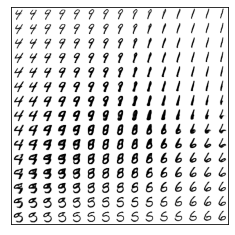

0.66745687 	 4951 	 213 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:19.589596
.....0.6686857 	 4956 	 213 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:19.589596
.....0.6686138 	 4961 	 213 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:19.589596
.....0.6736495 	 4966 	 213 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:19.589596
.....0.6668732 	 4971 	 213 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:19.589596
.....0.67525625 	 4976 	 214 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:19.589596
.....0.6631013 	 4981 	 214 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:18.589596
.....0.6661632 	 4986 	 214 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:18.589596
.....0.6685022 	 4991 	 214 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:18.589596
.....0.66528106 	 4996 	 214 	 2020-05-10 16:40:44.589596 	 2020-05-10 16:44:18.589596
....

In [17]:
batches_per_period = 5 # Как часто сохранять картинки
k_step = 5 # Количество шагов, которые могут делать дискриминатор и генератор во внутреннем цикле
t0 = time.time()
t0_oclock = datetime.datetime.now()
ran = 5000 # Количество шагов цикла

for i in range(ran):
    print('.', end='')
    # Достанем новый батч
    b0, b1 = next(train_batches_it)
    zp = np.random.randn(batch_size, latent_dim)
    # Шаги обучения дискриминатора
    for j in range(k_step):
#        l_d = step_d(b0, b1, zp)
        l_d = step_d(b0, zp)
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

#     Шаги обучения генератора
    for j in range(k_step):
#        l_d = step(b0, b1, zp)
        l_d = step(b0, zp, i)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    # Периодическое рисование результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(l_d,'\t', i + 1, '\t', int(time.time() - t0), '\t', t0_oclock, '\t',\
                                            t0_oclock + datetime.timedelta(seconds=int((time.time() - t0) / (i + 1) * ran)))

Создадим красивую гифку

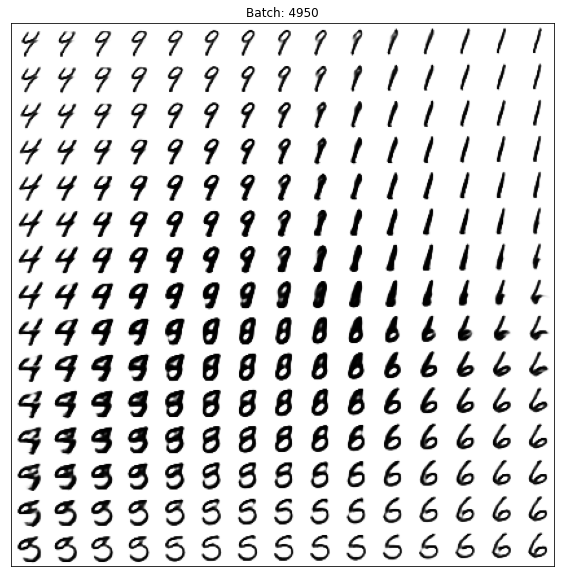

In [18]:
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, periods, fname, fig, batches_per_period): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys', norm=norm)
    plt.grid(None)
    plt.title("Batch: {}".format(0))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Batch: {}".format(periods[i]*batches_per_period))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

make_2d_figs_gif(figs, periods, "./figs/manifold_st.gif", plt.figure(figsize=(10,10)), batches_per_period)